In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np


In [154]:
plt.rcParams["figure.figsize"] = (10,5)

In [155]:
dataset= pd.read_csv("dataset.csv")
# drop the iron concetration column, as we are not allowed to use it
dataset.drop("% Iron Concentrate", axis=1)

for col in dataset.columns[1:]:
    dataset[col] = dataset[col].apply(lambda x: x.replace(",", "."))
    dataset[col] = dataset[col].astype(float)

dataset

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.20,16.98,3033.69,558.167,400.254,10.06970,1.74000,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737448,2017-09-09 23:00:00,49.75,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,...,313.695,392.160,430.702,872.008,418.725,497.548,446.357,416.892,64.27,1.71
737449,2017-09-09 23:00:00,49.75,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,...,236.700,401.505,404.616,864.409,418.377,506.398,372.995,426.337,64.27,1.71
737450,2017-09-09 23:00:00,49.75,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,...,225.879,408.899,399.316,867.598,419.531,503.414,336.035,433.130,64.27,1.71
737451,2017-09-09 23:00:00,49.75,23.20,1164.12,491.548,384.976,9.61686,1.65324,302.550,301.959,...,308.115,405.107,466.832,876.591,407.299,502.301,340.844,433.966,64.27,1.71


In [156]:
# check for missing values
print("Are there missing values?")
dataset.isna().values.any()

Are there missing values?


False

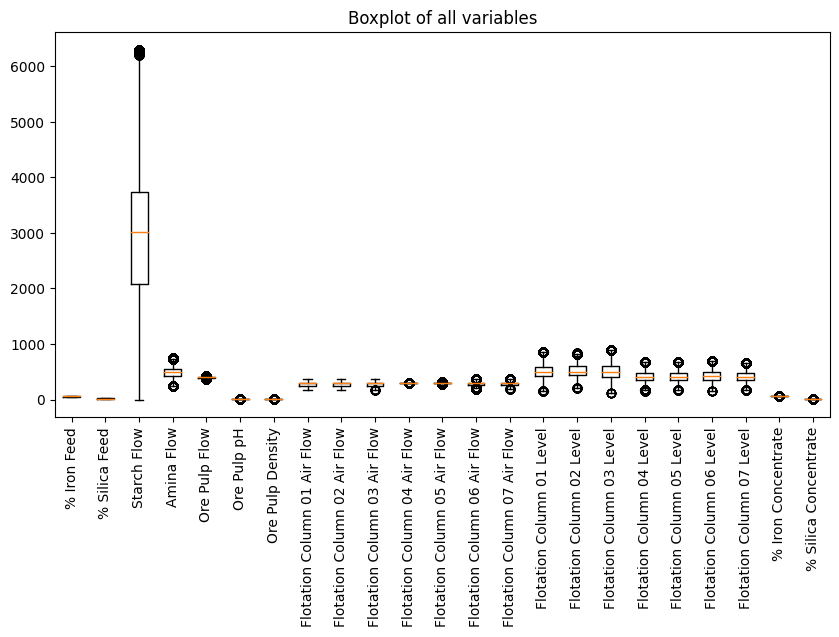

In [157]:
dataset_wo_date = dataset.drop("date", axis=1)

plt.title("Boxplot of all variables")
plt.boxplot(dataset_wo_date)
plt.xticks(range(1, len(dataset_wo_date.columns) + 1), dataset_wo_date.columns.to_list(), rotation=90)
plt.show()


In [158]:
# determine which timestamps are incomplete
def determine_incomplete_dates(df):
    last_date = df.date.iloc[0]
    current_count = 1
    invalid_counts = []
    for date in df.date.iloc[1:]:
        if last_date == date:
            current_count += 1
        else:
            if current_count != 180:
                invalid_counts.append((last_date, current_count))
            last_date = date
            current_count = 1

    if invalid_counts:
        print("Timestamps with missing values:")
        for timestamp, count in invalid_counts:
            print(f"{timestamp}: {count} samples")
    else:
        print("All dates have correct number of samples")

determine_incomplete_dates(dataset)


Timestamps with missing values:
2017-03-10 01:00:00: 174 samples
2017-04-10 00:00:00: 179 samples


In [159]:
# remove first 174 rows, as the measurement is incomplete
dataset.drop(index=dataset.index[:174], axis=0, inplace=True)

# duplicate the last row of the date with 179 measurements
line = dataset.loc[dataset.date == "2017-04-10 00:00:00"].tail(1)
iloc = dataset.index.get_loc(line.index.values[0])
dataset = pd.concat([dataset.iloc[:iloc], line, dataset.iloc[iloc:]]).reset_index(drop=True)

In [160]:
determine_incomplete_dates(dataset)

All dates have corrent number of samples


Timedelta 3600.0: 4094x
Timedelta 1148400.0: 1x


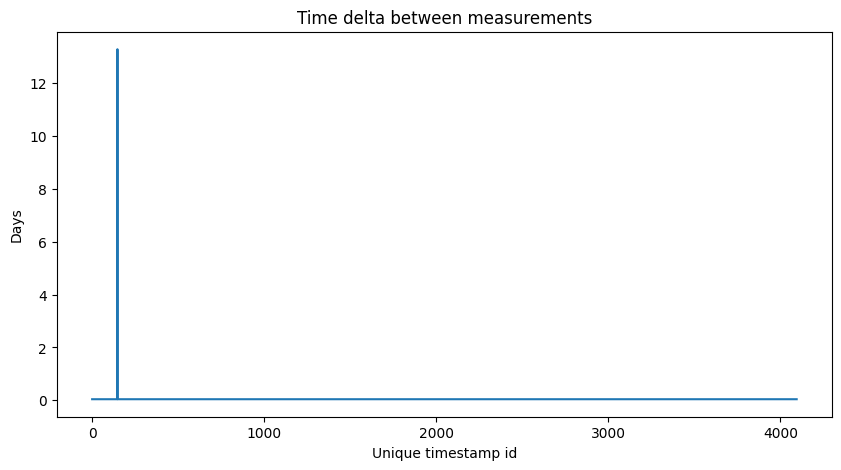

In [178]:
# check if timedelta is same throughout the dataset
def check_timedeltas(df):
    udates = df.date.unique()
    last = datetime.strptime(udates[0], '%Y-%m-%d %H:%M:%S')
    timedeltas = []
    for date in udates[1:]:
        dd = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        timedeltas.append((dd-last).total_seconds())
        last = dd

    timedeltas = np.array(timedeltas)
    unique, counts = np.unique(timedeltas, return_counts=True)
    for value, count in zip(unique, counts):
        print(f"Timedelta {value}: {count}x")
    return timedeltas

timedeltas = check_timedeltas(dataset)
plt.title("Time delta between measurements")
plt.plot(timedeltas/60/60/24)
plt.xlabel("Unique timestamp id")
plt.ylabel("Days")
plt.show()

In [170]:
# find the gap
udates = dataset.date.unique()
last = datetime.strptime(udates[0], '%Y-%m-%d %H:%M:%S')
for date in udates[1:]:
    dd = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    if (dd-last).total_seconds() != 3600.0:
        print(last)
    last = dd
    

2017-03-16 05:00:00


In [175]:
line = dataset.loc[dataset.date == "2017-03-16 05:00:00"].tail(1)
iloc = dataset.index.get_loc(line.index.values[0])

dataset_small = dataset.iloc[:iloc+1]
dataset_big = dataset.iloc[iloc+1:]

In [176]:
_ = check_timedeltas(dataset_small)

Timedelta 3600.0: 147x


In [177]:
_ = check_timedeltas(dataset_big)

Timedelta 3600.0: 3947x
